In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles, MakeScaffoldGeneric, GetScaffoldForMol
from typing import List, Tuple
from collections import defaultdict, Counter

In [2]:
import pandas as pd
import os
import pickle
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from conf_ensemble import ConfEnsembleLibrary
from tqdm import tqdm
from rdkit.Geometry.rdGeometry import Point3D
from rdkit import Chem
from ccdc.conformer import ConformerGenerator, MoleculeMinimiser
from ccdc.molecule import Molecule
from ccdc_rdkit_connector import CcdcRdkitConnector

In [3]:
# To be able to save conformer properties
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps) 

In [4]:
random.seed(42)

In [5]:
data_dir_path = 'data/'

In [6]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    all_CEL = pickle.load(f)

In [7]:
smiles_df = pd.read_csv(os.path.join(data_dir_path, 'smiles_df.csv'))

In [12]:
platinum_smiles = smiles_df[smiles_df['platinum']]['smiles'].values

In [13]:
all_mols = [ce.mol for smiles, ce in all_CEL.get_unique_molecules() if smiles not in platinum_smiles]

In [14]:
len(all_mols)

11095

In [15]:
def get_scaffold(mol, generic=False) :
    try :
        core = GetScaffoldForMol(mol)
        if generic :
            core = MakeScaffoldGeneric(mol=core)
        scaffold = Chem.MolToSmiles(core)
        return scaffold
    except :
        raise Exception('Didnt work')

In [17]:
all_generic_scaffolds = []
correct_smiles = []
for mol in all_mols :
    try :
        scaffold = get_scaffold(mol)
        all_generic_scaffolds.append(scaffold)
        correct_smiles.append(Chem.MolToSmiles(mol))
    except :
        print('Didnt work')

In [18]:
counter = Counter(all_generic_scaffolds)

In [19]:
print(len(counter))

7208


In [24]:
#http://rdkit.blogspot.com/2020/09/interactively-exploring-scaffoldnetwork.html
#from rdkit.Chem.Scaffolds.rdScaffoldNetwork import CreateScaffoldNetwork, ScaffoldNetworkParams
#snp = ScaffoldNetworkParams()
#sn = CreateScaffoldNetwork(all_mols, snp)

RDKit ERROR: [15:17:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10 11 12
[15:17:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10 11 12

RDKit ERROR: 
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


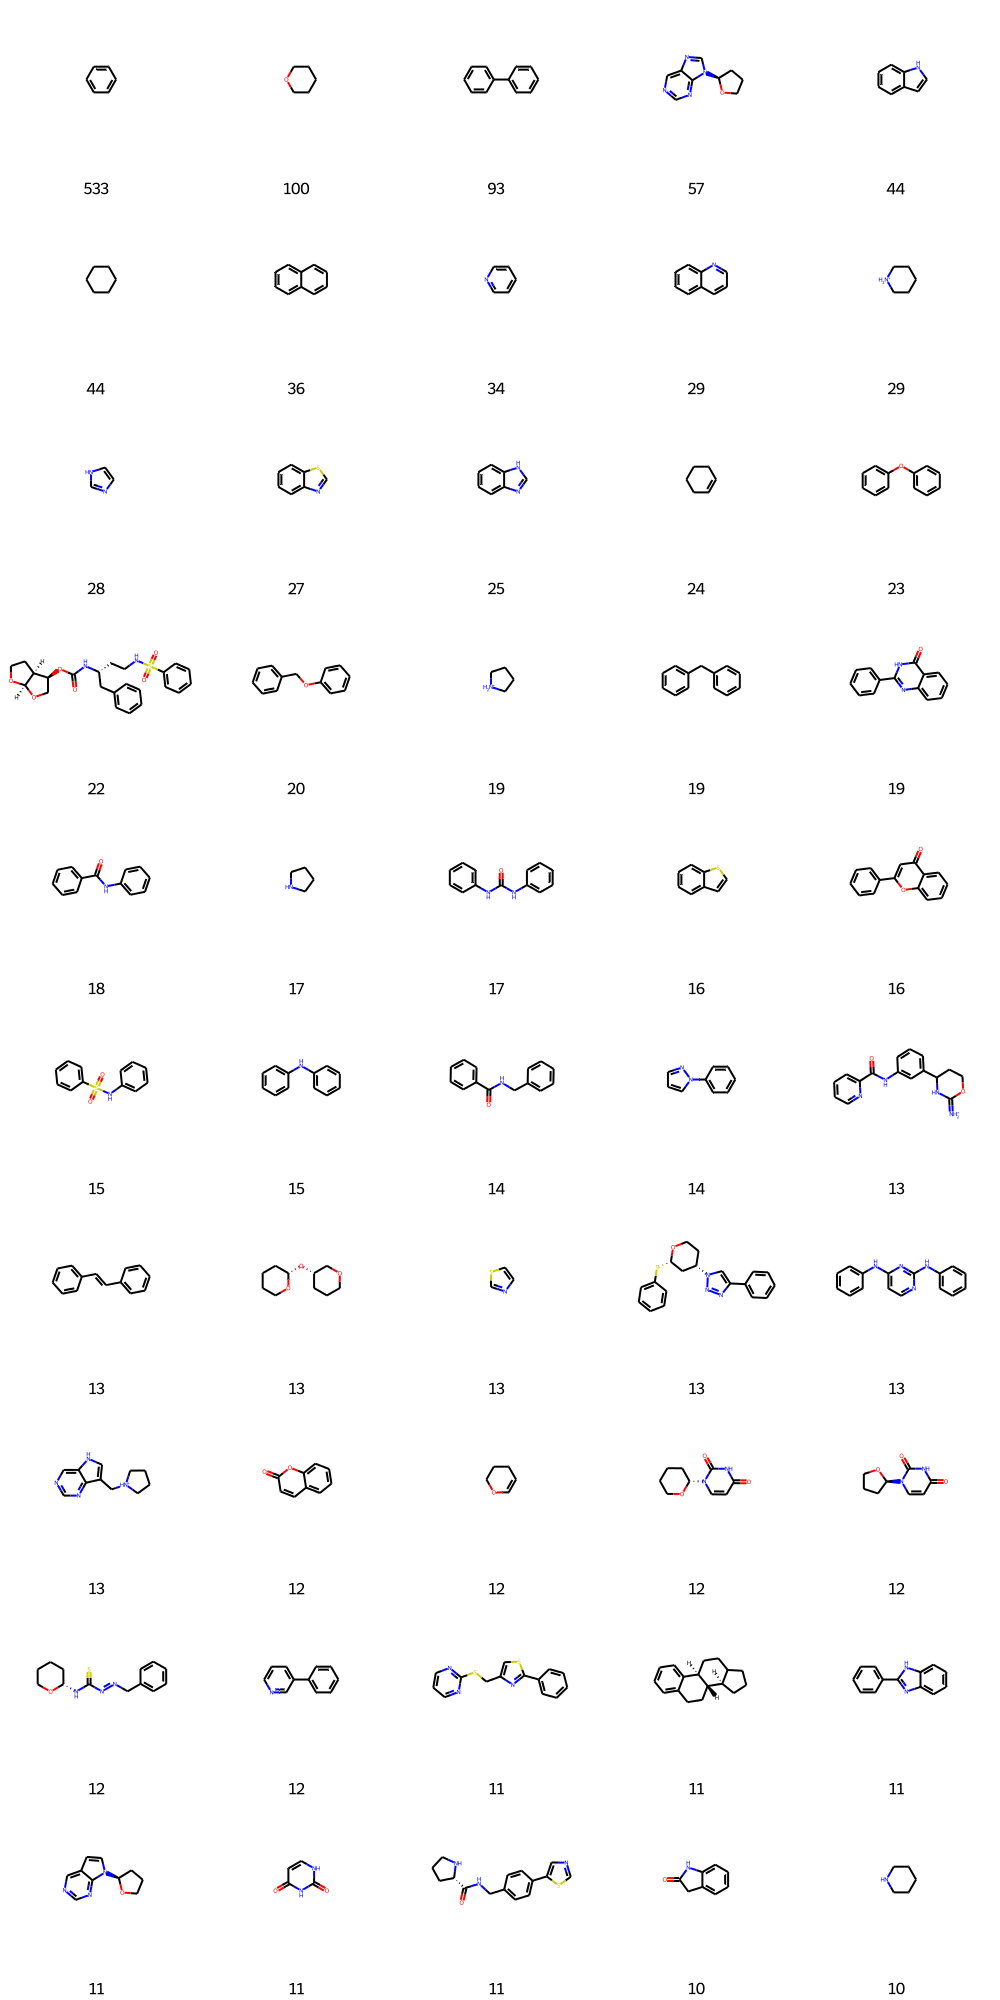

In [36]:
most_counted_scaffold = []
for scaffold, count in counter.most_common() :
    most_counted_scaffold.append(scaffold)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in counter.most_common() if scaffold != ''], 
                          molsPerRow=5,
                         legends=[str(count) for scaffold, count in counter.most_common() if scaffold != ''])

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

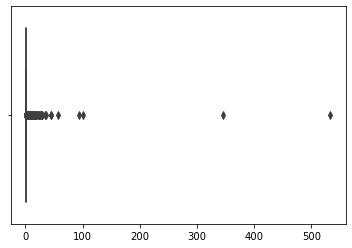

In [37]:
set_sizes = [count for scaffold, count in counter.items()]
sns.boxplot(set_sizes)

In [49]:
frac_train = 0.8
frac_val = 0.1

train_cutoff = int(frac_train * len(correct_smiles))
val_cutoff = int((frac_train + frac_val) * len(correct_smiles))
train_inds: List[int] = []
val_inds: List[int] = []
test_inds: List[int] = []

In [50]:
train_cutoff

8876

In [51]:
val_cutoff

9985

In [52]:
unique_scaffolds = list(counter.keys())

In [53]:
scaffold_splits_dir_name = 'scaffold_splits'
scaffold_splits_dir_path = os.path.join(data_dir_path, scaffold_splits_dir_name)
if not os.path.exists(scaffold_splits_dir_path) :
    os.mkdir(scaffold_splits_dir_path)

In [54]:
for i in range(5) :
    
    random.shuffle(unique_scaffolds)
    
    train_inds: List[int] = []
    val_inds: List[int] = []
    test_inds: List[int] = []
    
    for scaffold in unique_scaffolds:
        indices = [i for i, s in enumerate(all_generic_scaffolds) if s == scaffold]
        if len(train_inds) + len(indices) > train_cutoff:
            if len(train_inds) + len(val_inds) + len(indices) > val_cutoff:
                test_inds += indices
            else:
                val_inds += indices
        else:
            train_inds += indices
            
    train_smiles = [smiles for i, smiles in enumerate(correct_smiles) if i in train_inds]
    val_smiles = [smiles for i, smiles in enumerate(correct_smiles) if i in val_inds]
    test_smiles = [smiles for i, smiles in enumerate(correct_smiles) if i in test_inds]
    
    with open(os.path.join(scaffold_splits_dir_path, f'train_smiles_scaffold_split_{i}.txt'), 'w') as f :
        for smiles in train_smiles :
            f.write(smiles)
            f.write('\n')
        
    with open(os.path.join(scaffold_splits_dir_path, f'val_smiles_scaffold_split_{i}.txt'), 'w') as f :
        for smiles in val_smiles :
            f.write(smiles)
            f.write('\n')
        
    with open(os.path.join(scaffold_splits_dir_path, f'test_smiles_scaffold_split_{i}.txt'), 'w') as f :
        for smiles in test_smiles :
            f.write(smiles)
            f.write('\n')

In [55]:
len(train_inds)

8876

In [56]:
len(val_inds)

1109

In [57]:
len(test_inds)

1110